In [1]:
%load_ext autoreload
%autoreload 2

from readers import *
from models import *
from datalib import *
import config.config_create_trajectory as config

import matplotlib.pyplot as plt
import time as t
%matplotlib notebook

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
start_time = t.time()
print("Reading demonstration data")

f_task = PositionDataSet()

reader = RosbagReader('data/demo22.bag', topic='/demonstration_cartesian_impedance_controller/demonstration_control_state')
for i in range(len(reader.msgs)):
    dp = reader.next_datapoint()
    time = dp.time
    state = dp.value
    
    f_task.append(PositionDataPoint(time, state.F_task))

f_task.align_time()

print("--- %s seconds ---" % (t.time() - start_time))
print("Done")\

Reading demonstration data
--- 0.3932340145111084 seconds ---
Done


<IPython.core.display.Javascript object>


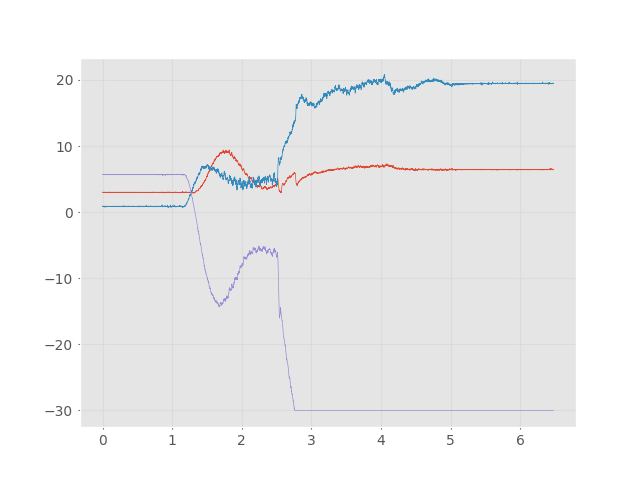

In [3]:
plt.figure()
labels = ['x','y','z']

for j in range(3):
    plt.plot(f_task.time, f_task.get_index(j).value, label=labels[j])

<IPython.core.display.Javascript object>


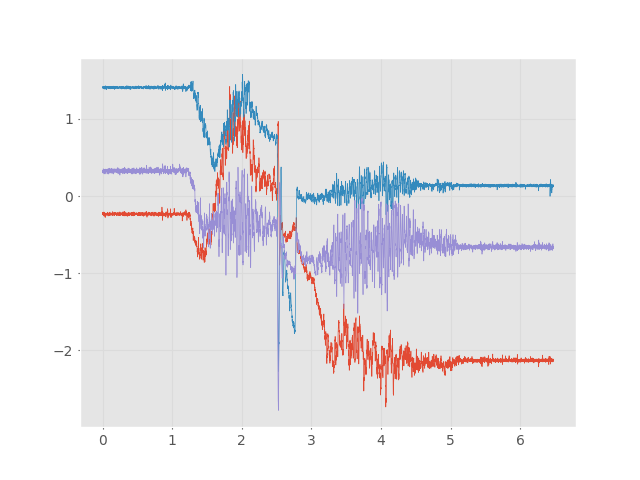

In [4]:
plt.figure()
labels = ['x','y','z']

for j in range(3):
    plt.plot(f_task.time, f_task.get_index(j+3).value, label=labels[j])